In [190]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [191]:
def f(x):
  return 3*x**2 - 4*x + 5

In [192]:
f(3.0)

20.0

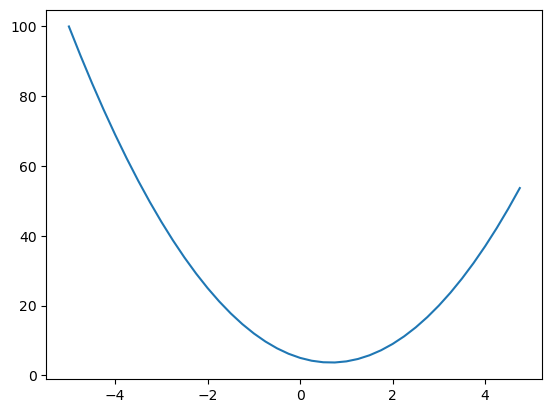

In [193]:
xs = np.arange (-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [194]:
h = 0.00000001
x = 3.0
(f(x + h) - f(x))/h

14.00000009255109

In [195]:
h = 0.00000001
x = -3.0
(f(x + h) - f(x))/h

-22.00000039920269

In [196]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [197]:
# more complex case
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [198]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 -d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [199]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# bumping h up for b
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 -d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [200]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# bumping h up for c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 -d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [201]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  # For adding
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out
  
  # For multiplying
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other
  
  def __truediv__(self, other): # other / self
    return self * other**-1
  
  def __neg__(self): # -self
    return self * -1
  
  def __sub__(self, other): # self - other
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward  
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out  

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# e = a * b; e.label = 'e'
# d = e + c; d.label = 'd'
# f = Value(-2.0, label='f')
# L = d * f; L.label= 'L'
# d

# for solving manually
# (a.__mul__(b)).__add__(c)

In [202]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [203]:
# a / b
# a * (1/b)
# a * (b**-1)

In [204]:
# d._prev

In [205]:
# d._op

In [206]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in v._prev:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [207]:
 # draw_dot(d)

In [208]:
# draw_dot(L)

#### def of derivative
- L = d * f
- dL/dd = ?

- (f(x + h) - f(x) / h)
- ((d + h) * f - d * f) / h
- (d * f + h * f - d * f) / h
- (h * f) / h
- f

* dd / dc = 1.0
* dd / de = 1.0
* d = c  + e

#### Want:
dL / dc = (dL / dd) * (dd / dc)

#### Know:
- dL / dd
- dd / dc

In [209]:
# one step of an optmization (extremely usueful for training neural networks)
# a.data += 0.01 * a.grad
# b.data += 0.01 * b.grad
# c.data += 0.01 * c.grad
# f.data += 0.01 * f.grad

# e = a * b
# d = e + c
# L = d * f

# print(L.data)

In [210]:
#a.grad = -2.0 * -3.0
#b.grad = -2.0 * 2.0

In [211]:
#c. grad = -2.0
#e.grad = -2.0

In [212]:
#f.grad = 4.0
# d.grad = -2

In [213]:
# def lol():

  # h = 0.001

  # a = Value(2.0, label = 'a')
  # b = Value(-3.0, label = 'b')
  # c = Value(10.0, label = 'c')
  # e = a * b; e.label = 'e'
  # d = e + c; d.label = 'd'
  # f = Value(-2.0, label = 'f')
  # L = d * f; L.label = 'L'
  # L1 = L.data

  # a = Value(2.0, label = 'a')
  # b = Value(-3.0, label = 'b')
  # c = Value(10.0, label = 'c')
  # e = a * b; e.label = 'e'
  # d = e + c; d.label = 'd'
  # f = Value(-2.0, label = 'f')
  # L = d * f; L.label = 'L'
  # L2 = L.data

  # print((L2 - L1)/h)

# lol()

In [214]:
# plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [215]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label= 'o'
o.backward()

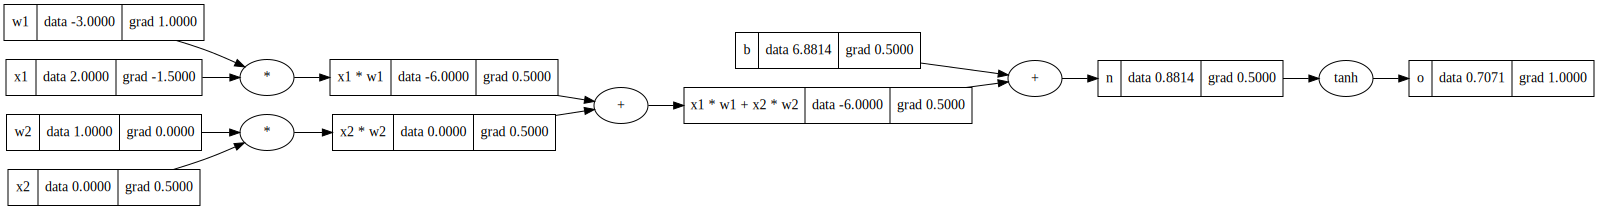

In [216]:
draw_dot(o)

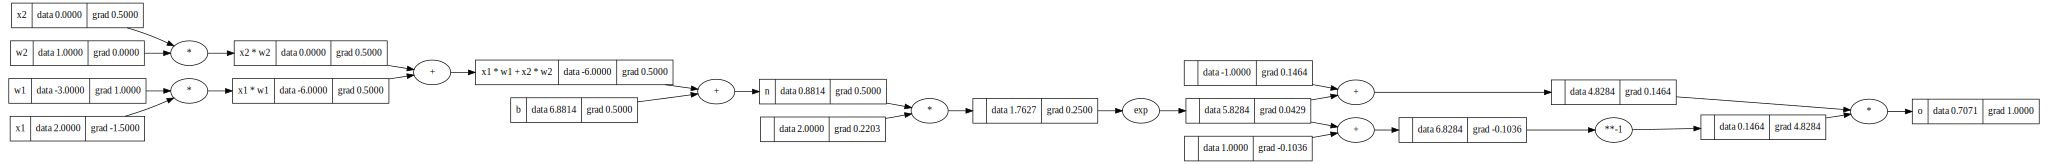

In [217]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp()
o = (e -1) / (e + 1)
# --- 
o.label= 'o'
o.backward()
draw_dot(o)

In [218]:
# o.backward()

In [219]:
# topological sort graph
# topo = []
# visited = set()
# def build_topo(v):
  # if v not in visited:
    # visited.add(v)
    # for child in v._prev:
     #  build_topo(child)
    # topo.append(v)
# build_topo(o)
# topo

In [220]:
#o.grad = 1.0

In [221]:
# without doing backP manually
# o._backward()

In [222]:
# n._backward()

In [223]:
# b._backward()

In [224]:
# x1w1x2w2._backward()

In [225]:
# x2w2._backward()
# x1w1._backward()

In [226]:
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

In [227]:
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

In [228]:
# x1w1.grad = 0.5
# x2w2.grad = 0.5

In [229]:
# x1w1x2w2.grad= 0.5
# b.grad = 0.5

In [230]:
# n.grad = 0.5

In [231]:
# o.grad = 1.0

In [232]:
# 1 - o.data**2

In [233]:
# o = tanh(n)
# do/dn = 1 - o**2

In [234]:
# debugging
#a = Value(3.0, label='a')
#b = a + a ; b.label = 'b'
#b.backward()
#draw_dot(b)

In [235]:
import torch

In [248]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [237]:
# o.item()

In [238]:
# x2.grad.item()

In [239]:
# torch.Tensor([2.0])

In [249]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [251]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.418984752203693)

In [256]:
# a simple dataset for NN
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [258]:
n.parameters()

[Value(data=-0.9887598104293918),
 Value(data=-0.7195026310306705),
 Value(data=-0.9203769470103966),
 Value(data=-0.36909355865795535),
 Value(data=-0.3335082361447801),
 Value(data=-0.7367200274906844),
 Value(data=-0.8593808501034799),
 Value(data=-0.0011446448921403896),
 Value(data=-0.4614113079819635),
 Value(data=0.6534197186256534),
 Value(data=-0.310501481909099),
 Value(data=-0.5548704324852309),
 Value(data=-0.9473703881394546),
 Value(data=0.39996374833413006),
 Value(data=-0.2805089896464463),
 Value(data=-0.2315124126680015),
 Value(data=0.14811917262279461),
 Value(data=-0.6843620374719364),
 Value(data=0.8850093084528214),
 Value(data=-0.8673914455887923),
 Value(data=0.322092829947457),
 Value(data=0.6802417596779295),
 Value(data=-0.6524872008644722),
 Value(data=-0.3840841511028519),
 Value(data=-0.46798170254444016),
 Value(data=-0.9919842561594749),
 Value(data=0.4144620676689521),
 Value(data=-0.24401138889322738),
 Value(data=-0.6222771152039617),
 Value(data=-0.

In [254]:
[(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.337578718171804),
 Value(data=1.0482312694774811),
 Value(data=1.6185815223264668),
 Value(data=0.9425872783354049)]

In [243]:
loss = sum((yout.data - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

5.726683257445039

In [244]:
print(type(loss))

<class 'float'>


In [246]:
loss.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [247]:
n.layers[0].neurons[0].w[0].grad

0.0